# Install Julia

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.9.3" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools DataFrames CSV Query Plots GLM"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.9.3 on the current Colab Runtime...
2023-12-01 02:24:45 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.9/julia-1.9.3-linux-x86_64.tar.gz [146268149/146268149] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package DataFrames...
Installing Julia package CSV...
Installing Julia package Query...
Installing Julia package Plots...
Installing Julia package GLM...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.9

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [1]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, broadwell)
  Threads: 3 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


# Question 1: Write a function

In [2]:
import Pkg; Pkg.add("StatsBase")
using StatsBase

function most_common_word(input::AbstractString)
    cleaned_words = split(lowercase(replace(input, r"[.,?!]" => "")))

    # Count occurrences of each word
    word_counts = countmap(cleaned_words)

    # Find the most common word
    get_counts(x) = get(word_counts, x, 0)
    most_common_word = argmax(get_counts,keys(word_counts))

    return most_common_word
end

test_string = "I bought a sandwich with a side of chips!"
result = most_common_word(test_string)
println("Most common word: ", result)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [2913bbd2] + StatsBase v0.34.2
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Most common word: a


# Question 2: Analyze a data set

In [9]:
using Pkg
Pkg.add(["DataFrames","CSV","Query", "Dates"])
using CSV
using DataFrames

# Read in the CSV file
file_path = "movie_reviews.csv"
movie_reviews = CSV.File(file_path) |> DataFrame

# Print the number of rows in the data set
num_rows = nrow(movie_reviews)
println("Number of rows in the data set: ", num_rows)

# Function to convert two-digit years to four-digit years
function convert_year(date_str)
    # if missing value
    if ismissing(date_str) || date_str == ""
        return missing
    end
    # in format of DD/MM/YY
    year = parse(Int, split(date_str, '/')[end])
    # Assuming that movies are from the 20th or 21st century
    if year > 22  # If the year is greater than 22, it is likely from the 1900s
        year += 1900
    else
        year += 2000
    end
    return year
end
# Apply the function to the 'in_theaters_date' column
movie_reviews[!, :Year] = [convert_year(d) for d in movie_reviews[!, :in_theaters_date]]
# Filter the data to contain only movies released before 2010, ignoring missing years
movies_pre_2010 = filter(row -> !ismissing(row.Year) && row.Year < 2010, movie_reviews)
# Calculate the average number of audience reviews for movies before 2010
average_reviews_pre_2010 = mean(skipmissing(movies_pre_2010[!, :audience_count]))
# Filter for popular movies (more reviews than the average), ignoring missing audience counts
popular_movies_pre_2010 = filter(row -> !ismissing(row.audience_count) && row.audience_count > average_reviews_pre_2010, movies_pre_2010)
# Print the number of rows in the filtered dataset
num_rows_popular_pre_2010_corrected = nrow(popular_movies_pre_2010)
println("Number of popular movies pre-2010: ", num_rows_popular_pre_2010_corrected)

# distribution of ratings
rating_percentages = combine(groupby(popular_movies_pre_2010, :rating), :rating => (count = length))
rating_percentages[!,:percentage] = rating_percentages.rating_length/ sum(rating_percentages.rating_length) * 100
println(rating_percentages)
# Insight:
println("Insight: Movies under R and PG-13 are most, which take 74% movies")

# Engineering a new feature
popular_movies_pre_2010[!,:is_highly_rated] = popular_movies_pre_2010.audience_count .> 2 * average_reviews_pre_2010
summary_table = combine(groupby(popular_movies_pre_2010, :is_highly_rated), :is_highly_rated => (count = length))
println()
println(summary_table)
# Insight:
println("Insight: Over half of the movies are highly rated, which means their audience count is higher than twice the average")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Number of rows in the data set: 16638
Number of popular movies pre-2010: 998
5×3 DataFrame
 Row │ rating   rating_length  percentage 
     │ String7  Int64          Float64    
─────┼────────────────────────────────────
   1 │ PG                 195    19.5391
   2 │ R                  323    32.3647
   3 │ NR                   1     0.1002
   4 │ G                   64     6.41283
   5 │ PG-13              415    41.5832
Insight: Movies under R and PG-13 are most, which take 74% movies

2×2 DataFrame
 Row │ is_highly_rated  is_highly_rated_length 
     │ Bool             Int64                  
─────┼─────────────────────────────────────────
   1 │           false                     611
   2 │            true                     387
Insight: Over half of the movies are highly rated, which means their audience count is higher than twice the average


# Question 3: Explore an external library

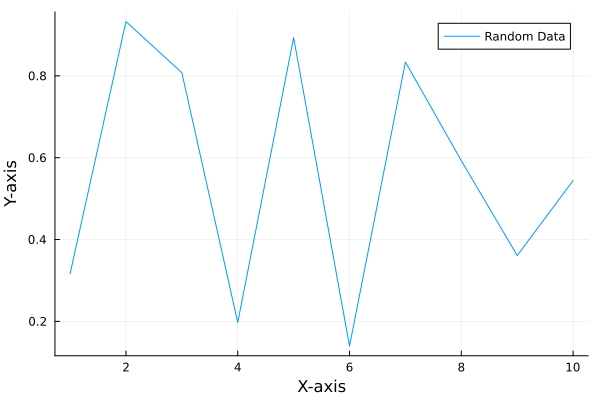

In [6]:
# Using Plots library for data visualization
using Plots

# Example: Creating a simple plot using the Plots library
x = 1:10
y = rand(10)
plot(x, y, label="Random Data", xlabel="X-axis", ylabel="Y-axis", legend=:topright)

# Question 4

Python:

* **Summary**: Python is a high-level, interpreted language known for its simplicity and readability. Its extensive libraries for data analysis, visualization, machine learning, and more make it a favorite among data scientists.

* **Strengths**: Vast selection of libraries (like pandas, NumPy, scikit-learn, TensorFlow, and matplotlib), large community, versatility across domains, great for prototyping and production.

* **Weaknesses**: Slower than compiled languages, Global Interpreter Lock (GIL) can hinder performance in multi-threaded applications.

R:

* **Summary**: R is a language specifically designed for statistical analysis and data visualization. It's favored by statisticians and data miners.

* **Strengths**: Rich set of packages for statistical analysis (like ggplot2, dplyr, tidyr), excellent for exploratory work, and has strong data visualization capabilities.

* **Weaknesses**: Less versatile outside of statistics, steeper learning curve for programming fundamentals, can be less memory efficient.

Rust:

* **Summary**: Rust is a multi-paradigm, compiled language focused on safety and performance. It's not traditionally used for data science, but it's gaining traction for system-level tools.

* **Strengths**: Memory safety without garbage collection, concurrency without data races, excellent performance, growing library ecosystem.

* **Weaknesses**: Steep learning curve, smaller community for data science, limited libraries for data science compared to Python and R.

Scala:

* **Summary**: Scala is a high-level language that integrates features of object-oriented and functional languages. It is often used in big data processing.

* **Strengths**: Runs on the JVM (Java Virtual Machine), great for parallel processing and big data (e.g., Apache Spark), statically typed, functional programming capabilities.

* **Weaknesses**: More complex syntax compared to Python, smaller community for data science, slower iteration times for development.

Julia:

* **Summary**: Julia is a high-level, high-performance, dynamic language designed for technical computing. It excels in numerical and computational science tasks.

* **Strengths**: Just-in-time (JIT) compilation leads to high performance, designed for numerical and scientific computing, easy to write performant code, good for handling large datasets.

* **Weaknesses**: Younger ecosystem, fewer libraries than Python, smaller community, the need for compilation can slow down the development process.